In [1]:
%load_ext autoreload
%autoreload 2

In [56]:
import logging
import re
import string
import warnings
from pathlib import Path
from time import time

import arviz as az
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotnine as gg
import pymc3 as pm
import seaborn as sns
from theano import tensor as tt

from src.data_processing import achilles as achelp
from src.data_processing import common as dphelp
from src.globals import PYMC3
from src.io import cache_io, model_config
from src.loggers import logger, set_console_handler_level
from src.modeling import pymc3_analysis as pmanal
from src.modeling import pymc3_sampling_api as pmapi
from src.models import configuration, speclet_model
from src.models.speclet_five import SpecletFive
from src.models.speclet_four import SpecletFour
from src.models.speclet_seven import SpecletSeven
from src.plot.color_pal import FitMethodColors, ModelColors, SeabornColor

In [3]:
notebook_tic = time()

set_console_handler_level(logging.WARNING)
warnings.simplefilter(action="ignore", category=UserWarning)

gg.theme_set(
    gg.theme_bw()
    + gg.theme(
        figure_size=(4, 4),
        axis_ticks_major=gg.element_blank(),
        strip_background=gg.element_blank(),
    )
)
%config InlineBackend.figure_format = "retina"

RANDOM_SEED = 847
np.random.seed(RANDOM_SEED)
HDI_PROB = PYMC3.HDI_PROB

In [9]:
def build_and_load_caches(name: str) -> speclet_model.SpecletModel:
    sp = configuration.get_config_and_instantiate_model(
        model_config.get_model_config(),
        name=name,
        root_cache_dir=cache_io.default_cache_dir(),
    )
    sp.build_model()
    if sp.cache_manager.mcmc_cache_exists() and sp.cache_manager.advi_cache_exists():
        _ = sp.load_advi_cache()
        _ = sp.load_mcmc_cache()
    else:
        print("Either the MCMC or ADVI cache does not exist for '{sp.name}'.")
    return sp


sp4_centered_cn: SpecletFour = build_and_load_caches("sp4-centered-copynum")
sp4_noncentered_cn: SpecletFour = build_and_load_caches("sp4-noncentered-copynum")

[07/10/21 11:58:45] WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1625932725.764321-219586;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:250
                             genes.

                    WARNING  Dropping 0 data points with missing   ]8;id=1625932725.775211-276649;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:260
                             copy number.

[07/10/21 11:58:48] WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1625932728.371524-253552;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:250
                             genes.

                    WARNING  Dropping 0 data points with missing   ]8;id=1625932728.3919759-894197;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:260
                             copy number.

sp4-centered-copynum


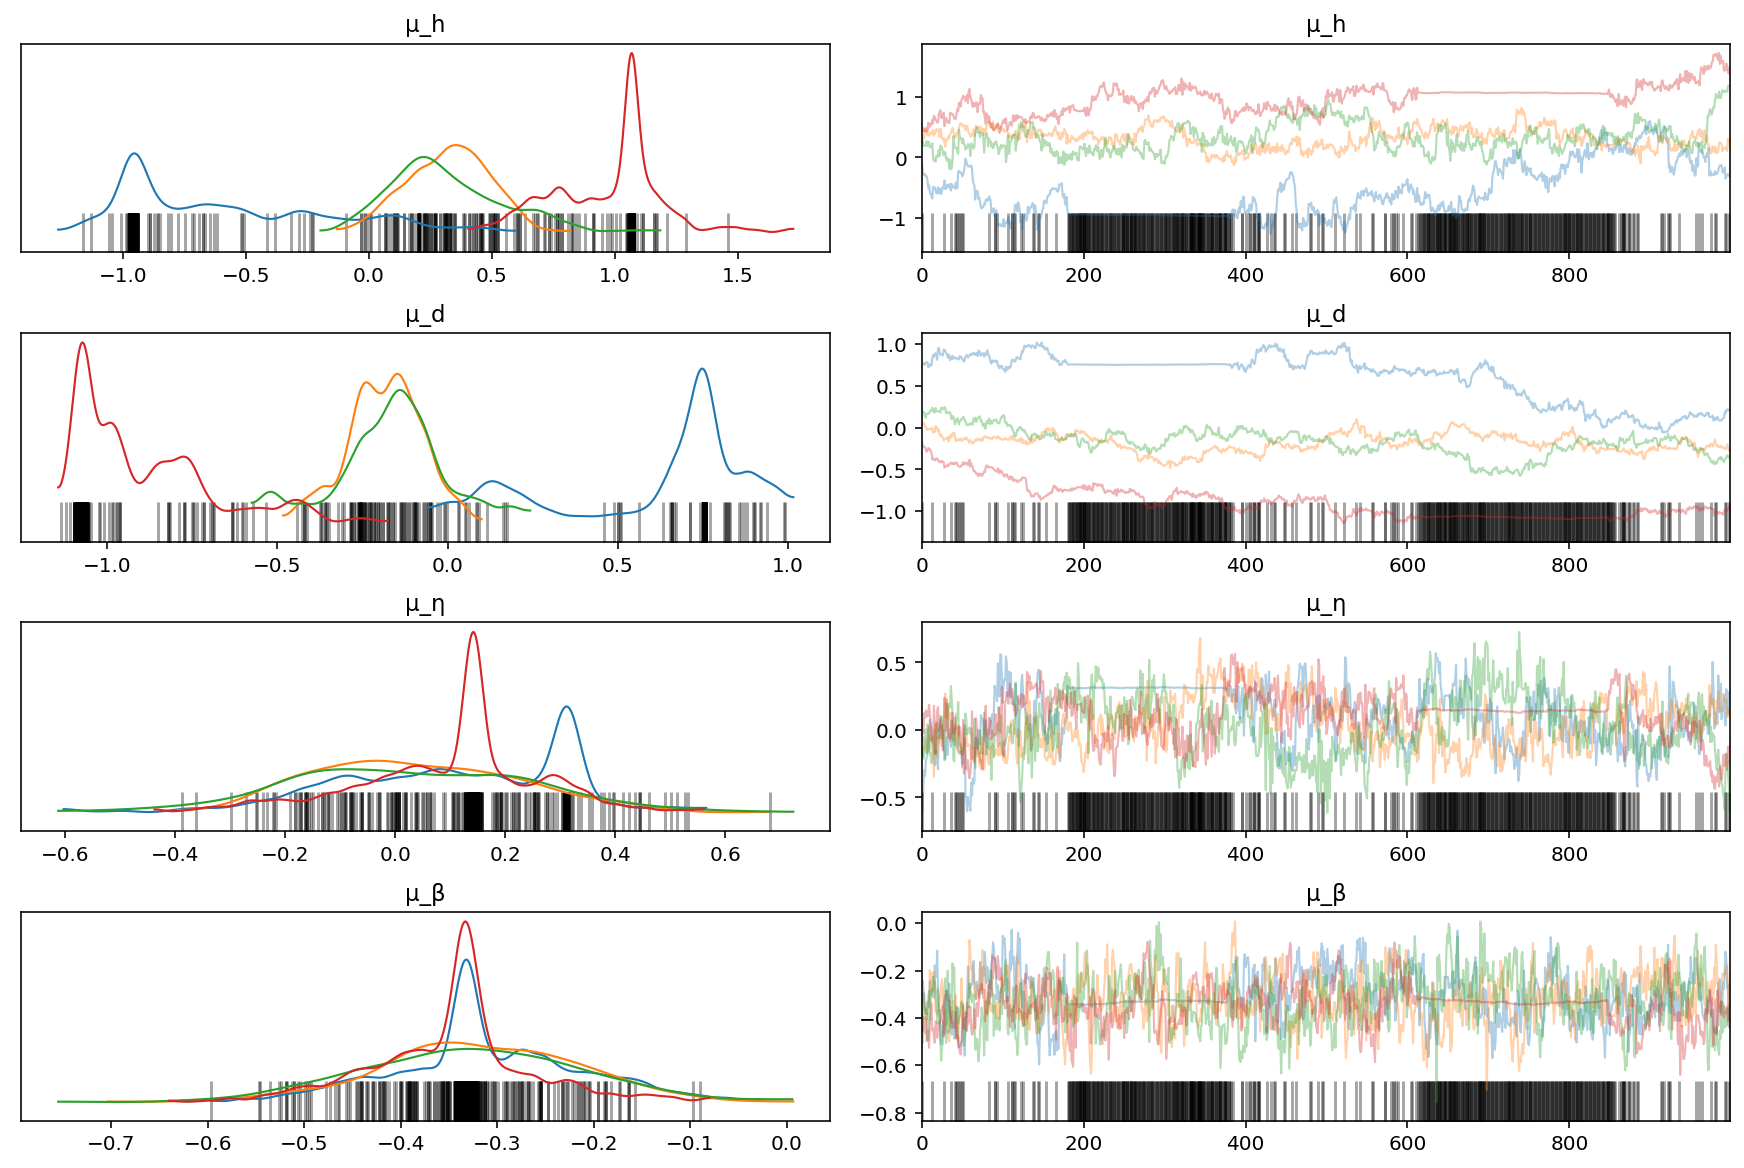

sp4-noncentered-copynum


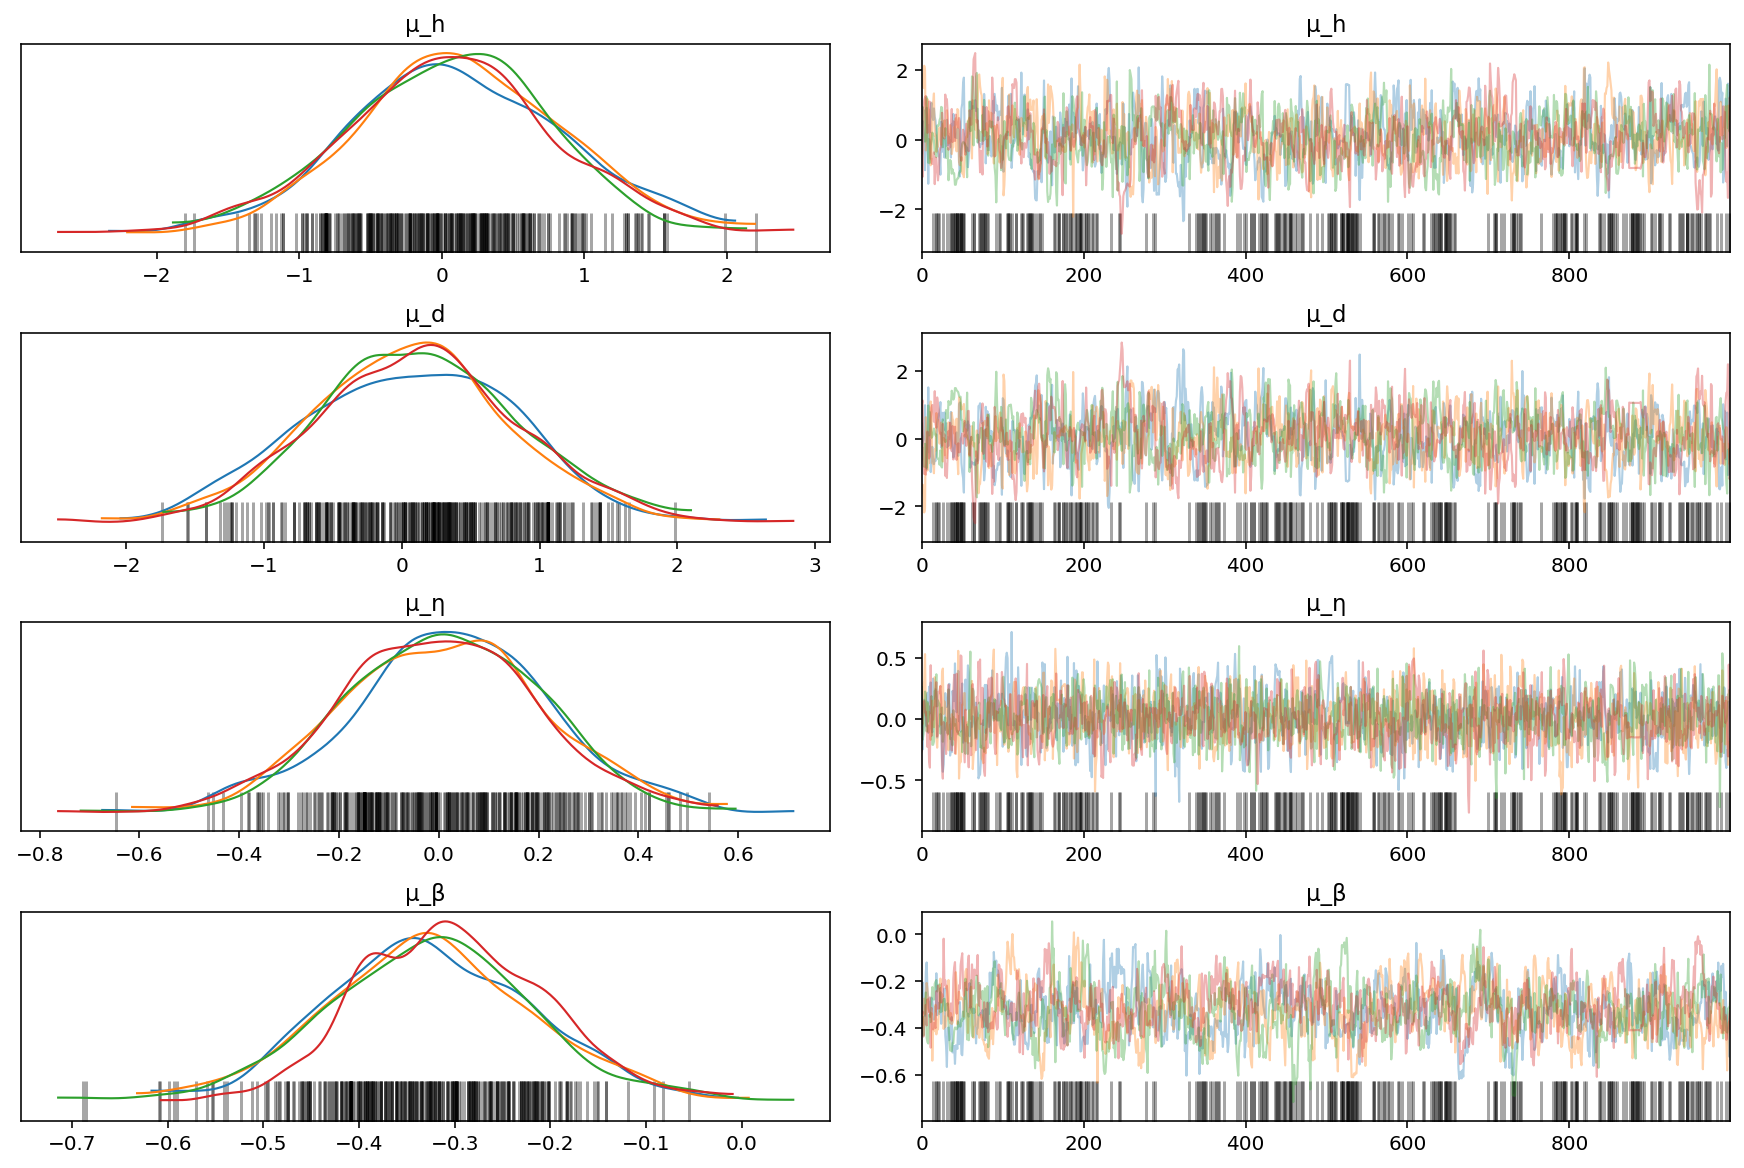

In [10]:
for sp in (sp4_centered_cn, sp4_noncentered_cn):
    print(sp.name)
    az.plot_trace(
        sp.mcmc_results, var_names=["μ_h", "μ_d", "μ_η", "μ_β"], compact=False
    )
    plt.show()

In [12]:
sp5_centered: SpecletFour = build_and_load_caches("sp5-default")
sp5_noncentered: SpecletFour = build_and_load_caches("sp5-noncentered")

[07/10/21 12:17:56] WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1625933876.867881-119898;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:250
                             genes.

                    WARNING  Dropping 0 data points with missing   ]8;id=1625933876.880779-472556;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:260
                             copy number.

[07/10/21 12:18:00] WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1625933880.579124-847645;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:250
                             genes.

                    WARNING  Dropping 0 data points with missing   ]8;id=1625933880.587369-432540;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:260
                             copy number.

sp5-default


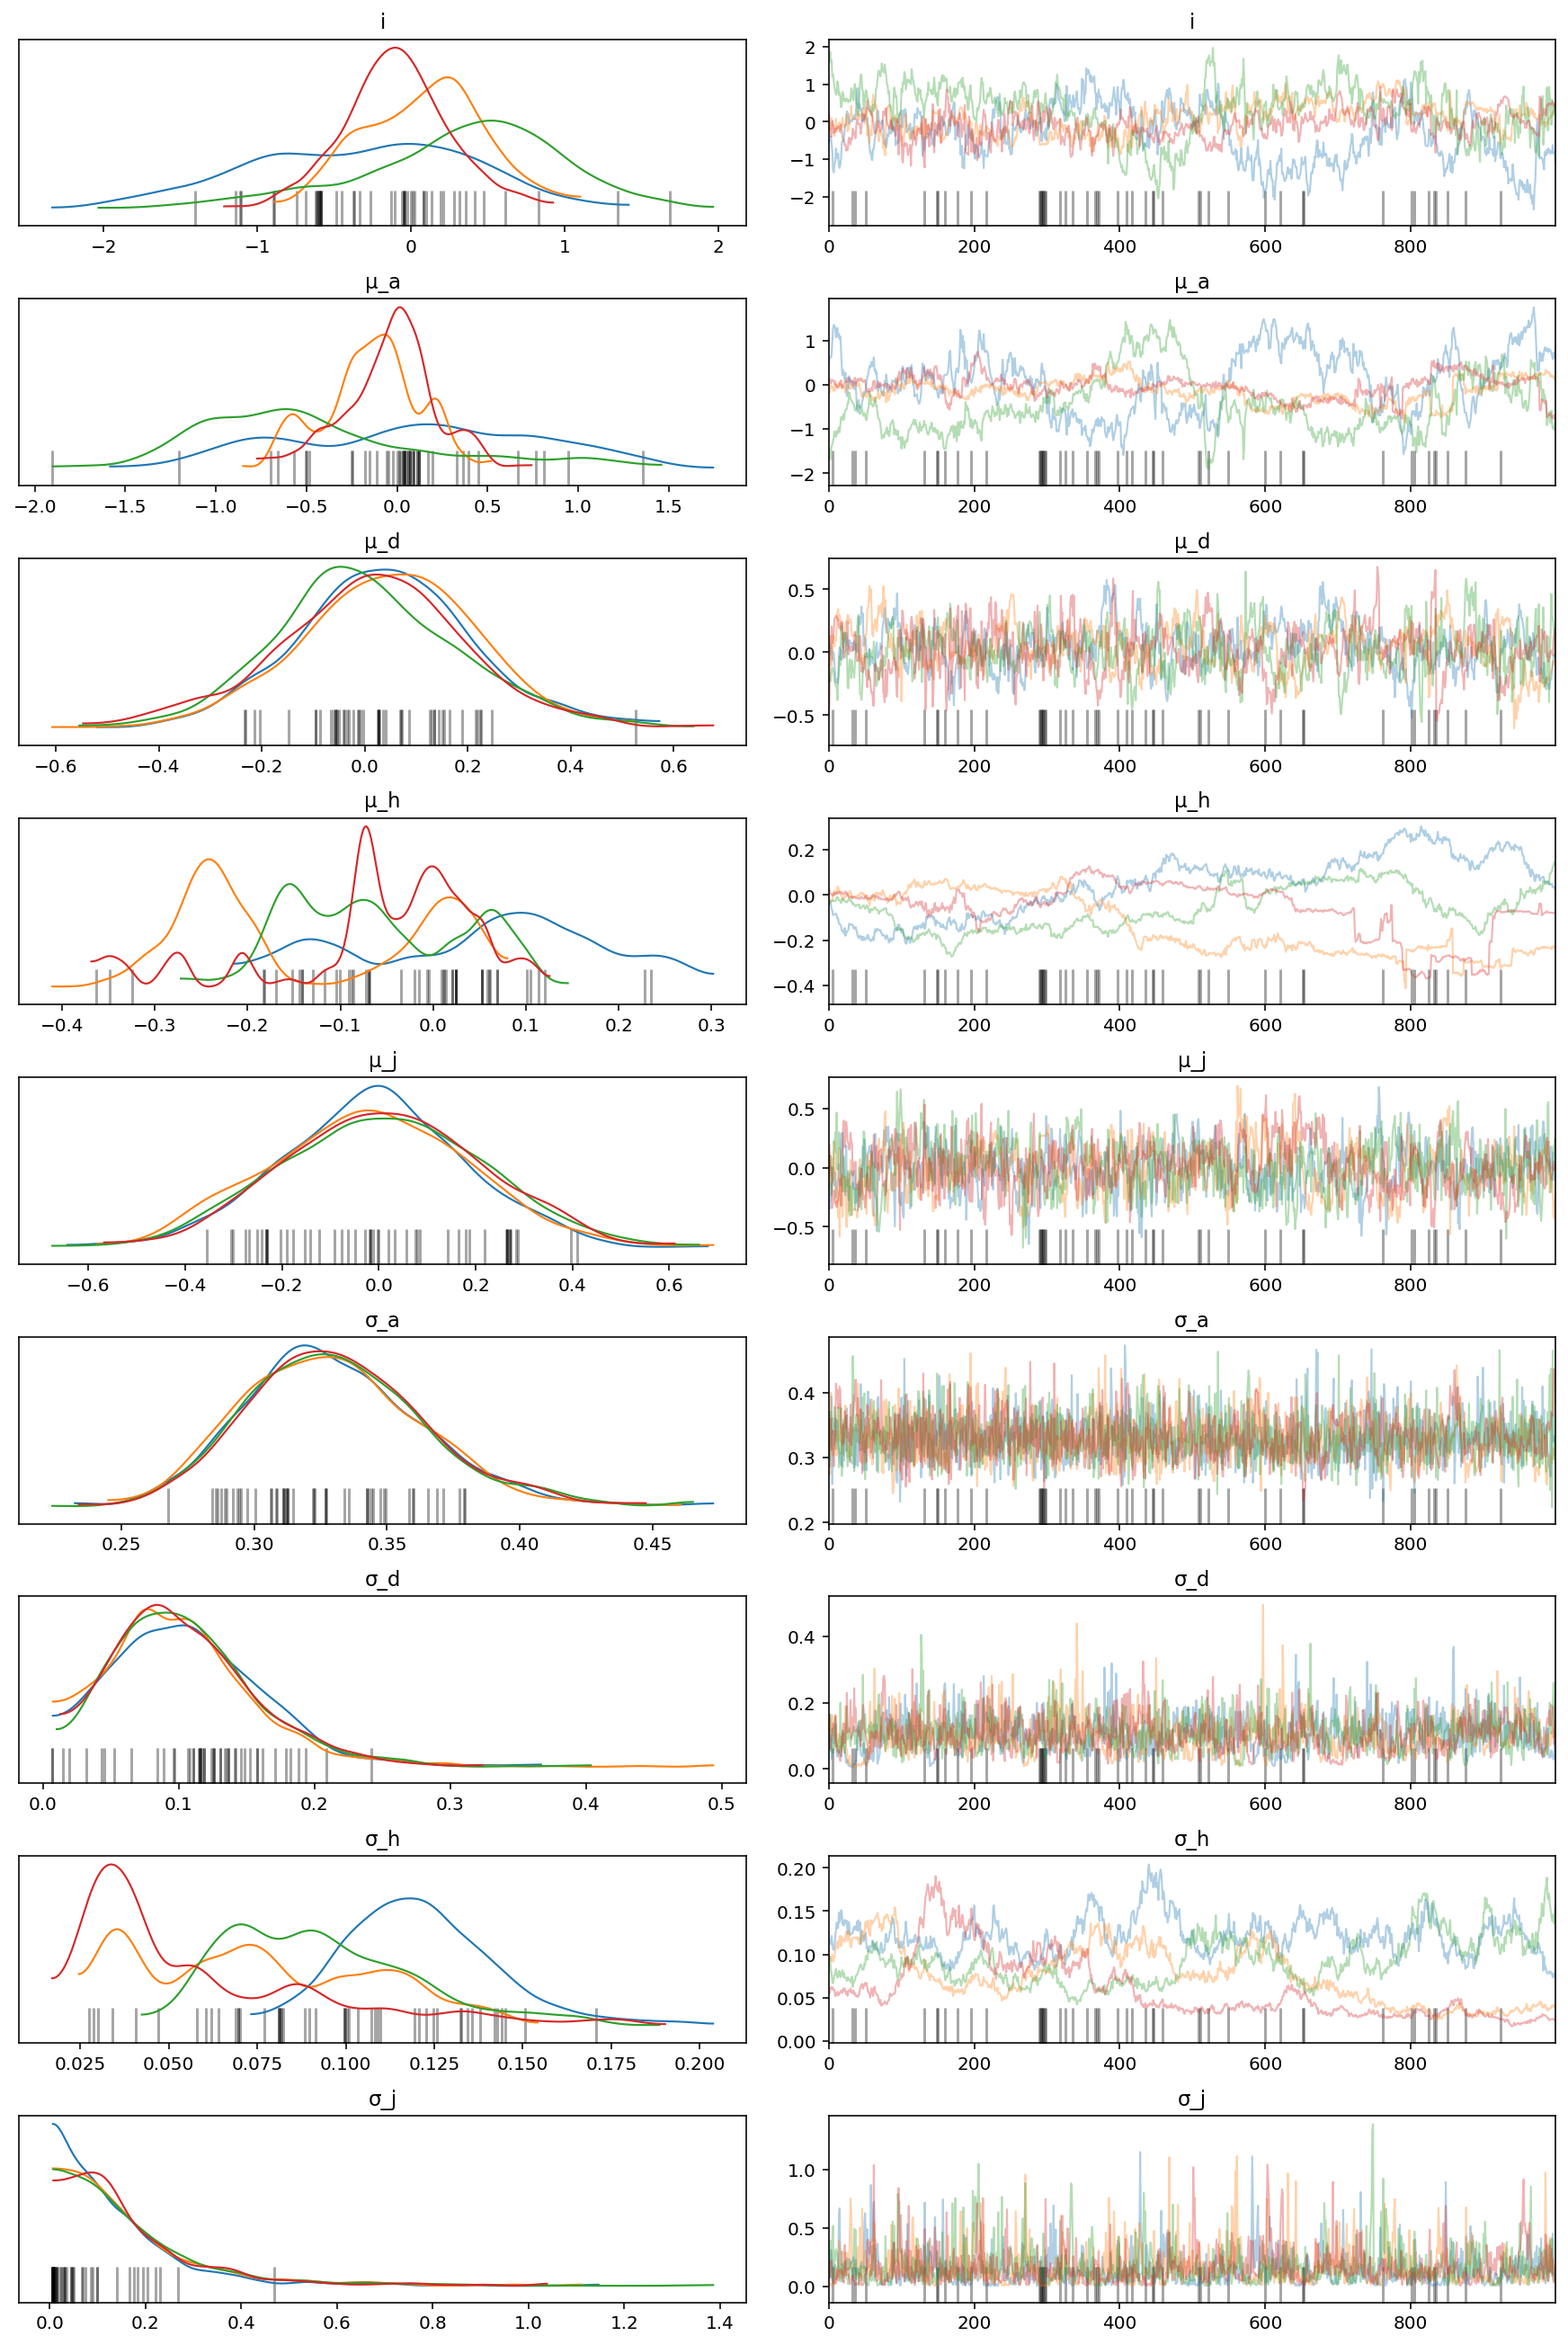

sp5-noncentered


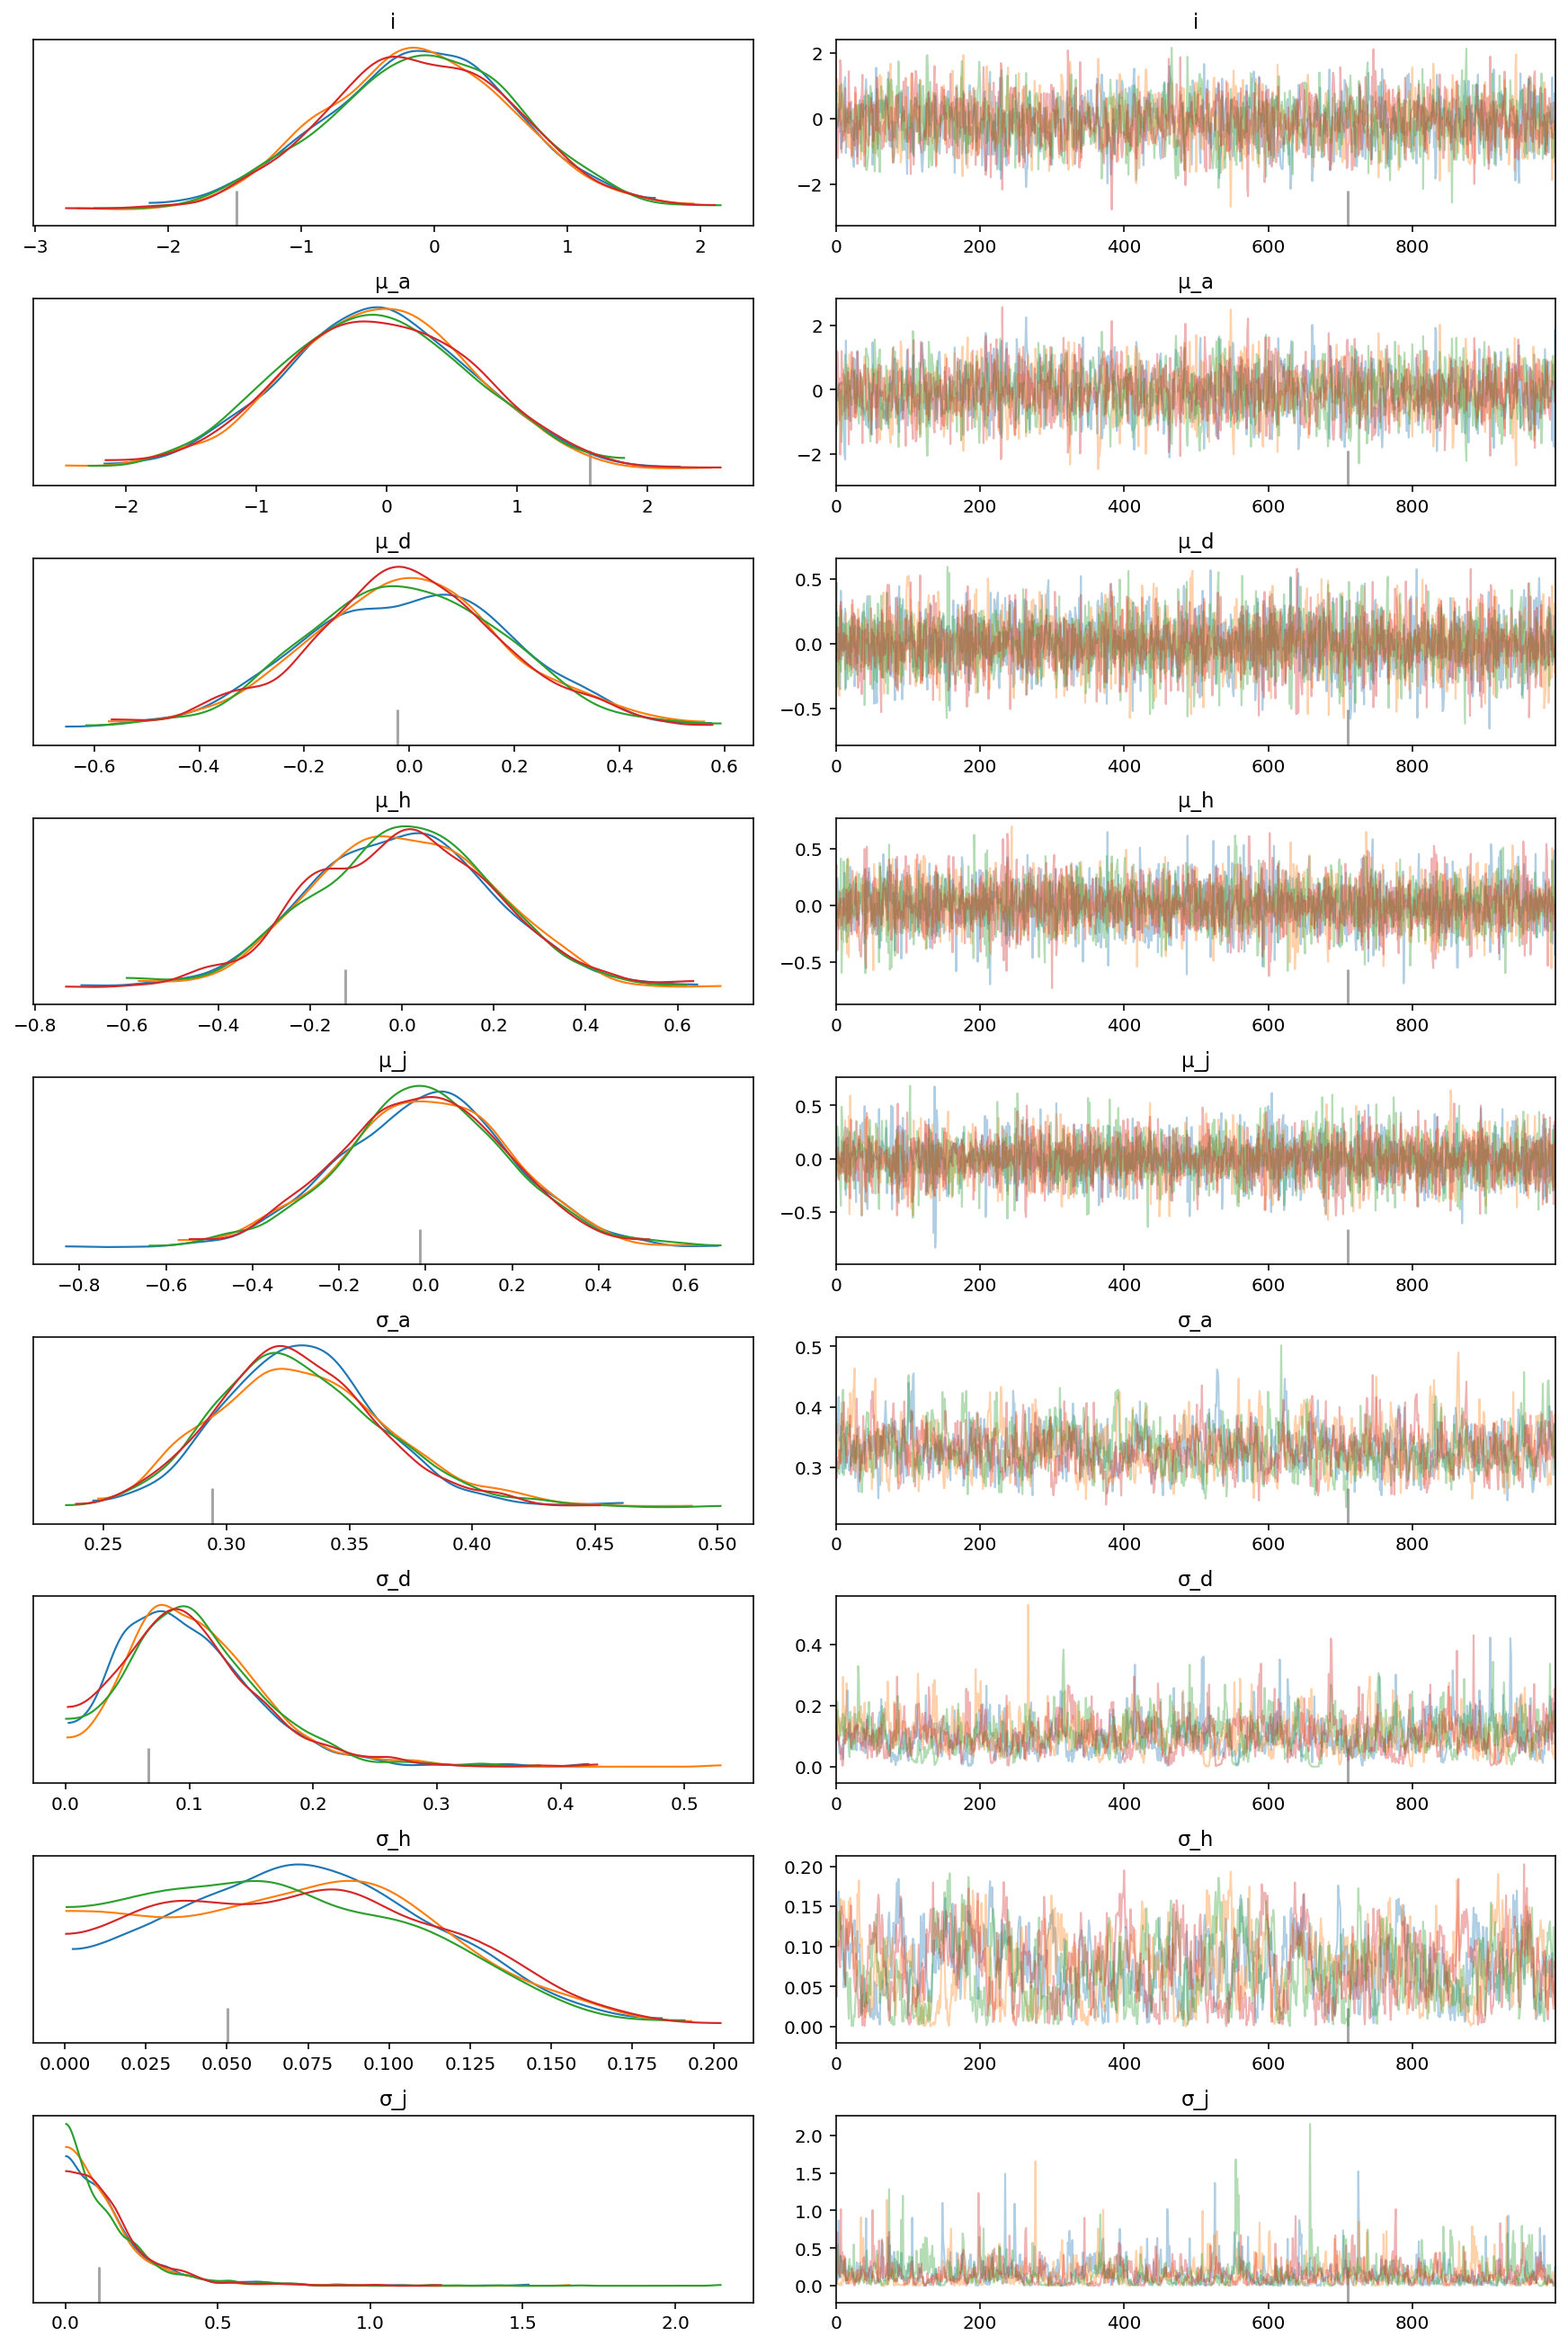

In [17]:
hyper_priors = [f"μ_{v}" for v in ("a", "d", "h", "j")]
hyper_priors += [f"σ_{v}" for v in ("a", "d", "h", "j")]
for sp in (sp5_centered, sp5_noncentered):
    print(sp.name)
    az.plot_trace(sp.mcmc_results, var_names=["i"] + hyper_priors, compact=False)
    plt.show()

In [39]:
genes = sp5_noncentered.data_manager.get_data()["hugo_symbol"].cat.categories.tolist()
cell_lines = sp5_noncentered.data_manager.get_data()[
    "depmap_id"
].cat.categories.tolist()

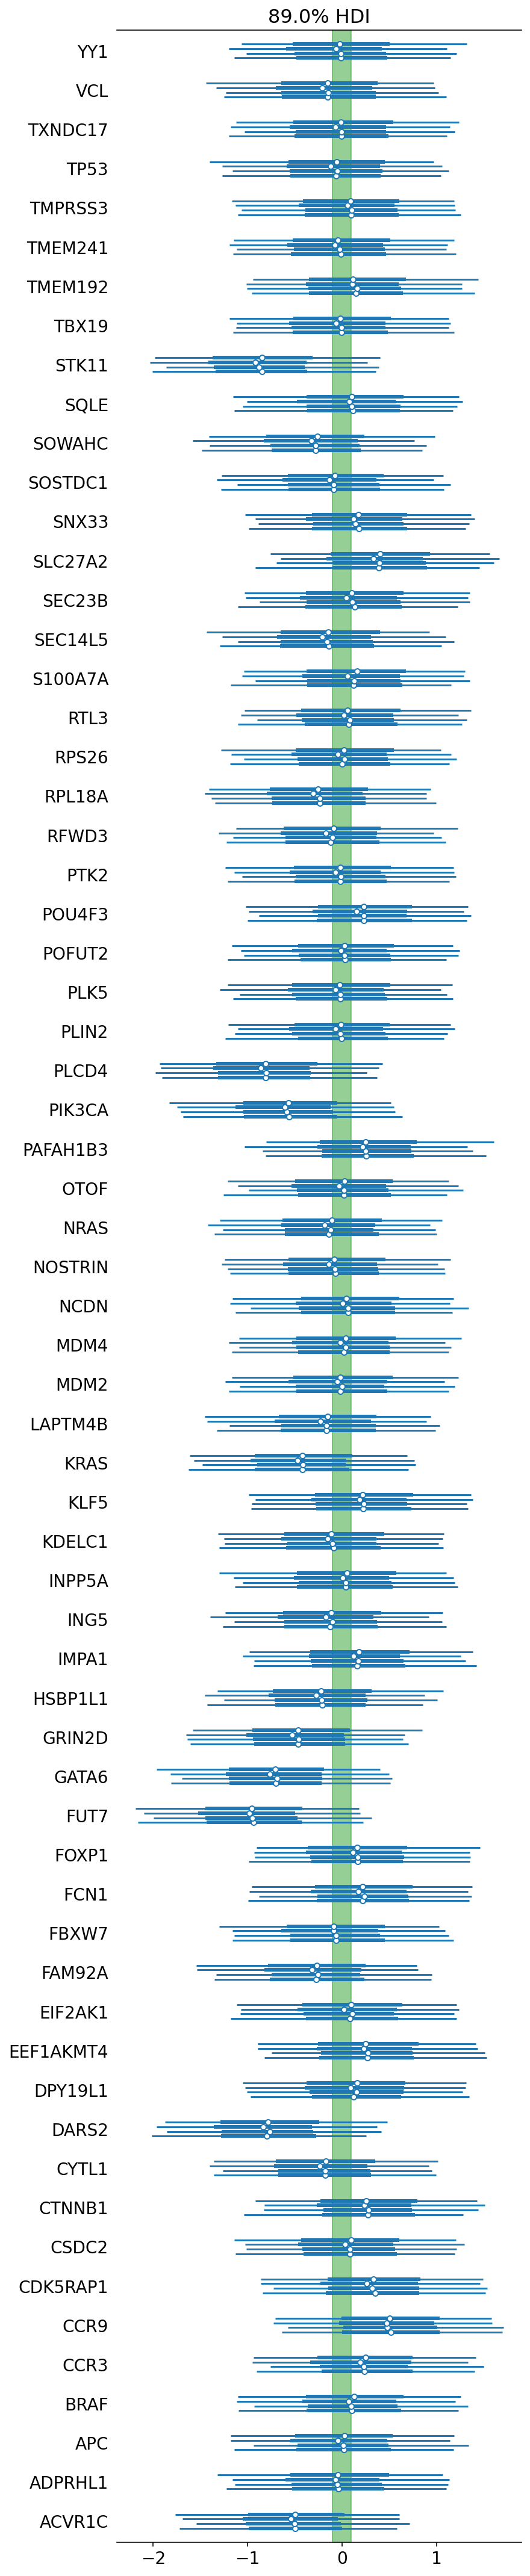

In [40]:
axes = az.plot_forest(
    sp5_noncentered.mcmc_results,
    var_names=["a"],
    rope=(-0.1, 0.1),
    hdi_prob=PYMC3.HDI_PROB,
)
axes[0].set_yticklabels(genes)
plt.show()

In [51]:
sp5_posterior_a = az.summary(
    sp5_noncentered.mcmc_results, var_names="a", hdi_prob=PYMC3.HDI_PROB
)
sp5_posterior_a["hugo_symbol"] = genes
sp5_posterior_a.head()

mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  ess_bulk  \
a[0] -0.026  0.732    -1.163      1.152      0.015    0.011    2398.0   
a[1] -0.161  0.734    -1.342      1.012      0.015    0.011    2441.0   
a[2] -0.016  0.736    -1.122      1.201      0.015    0.011    2433.0   
a[3] -0.076  0.734    -1.277      1.063      0.015    0.011    2380.0   
a[4]  0.089  0.735    -1.129      1.208      0.015    0.011    2404.0   

      ess_tail  r_hat hugo_symbol  
a[0]    2770.0    1.0      ACVR1C  
a[1]    2707.0    1.0     ADPRHL1  
a[2]    2474.0    1.0         APC  
a[3]    2694.0    1.0        BRAF  
a[4]    2874.0    1.0        CCR3

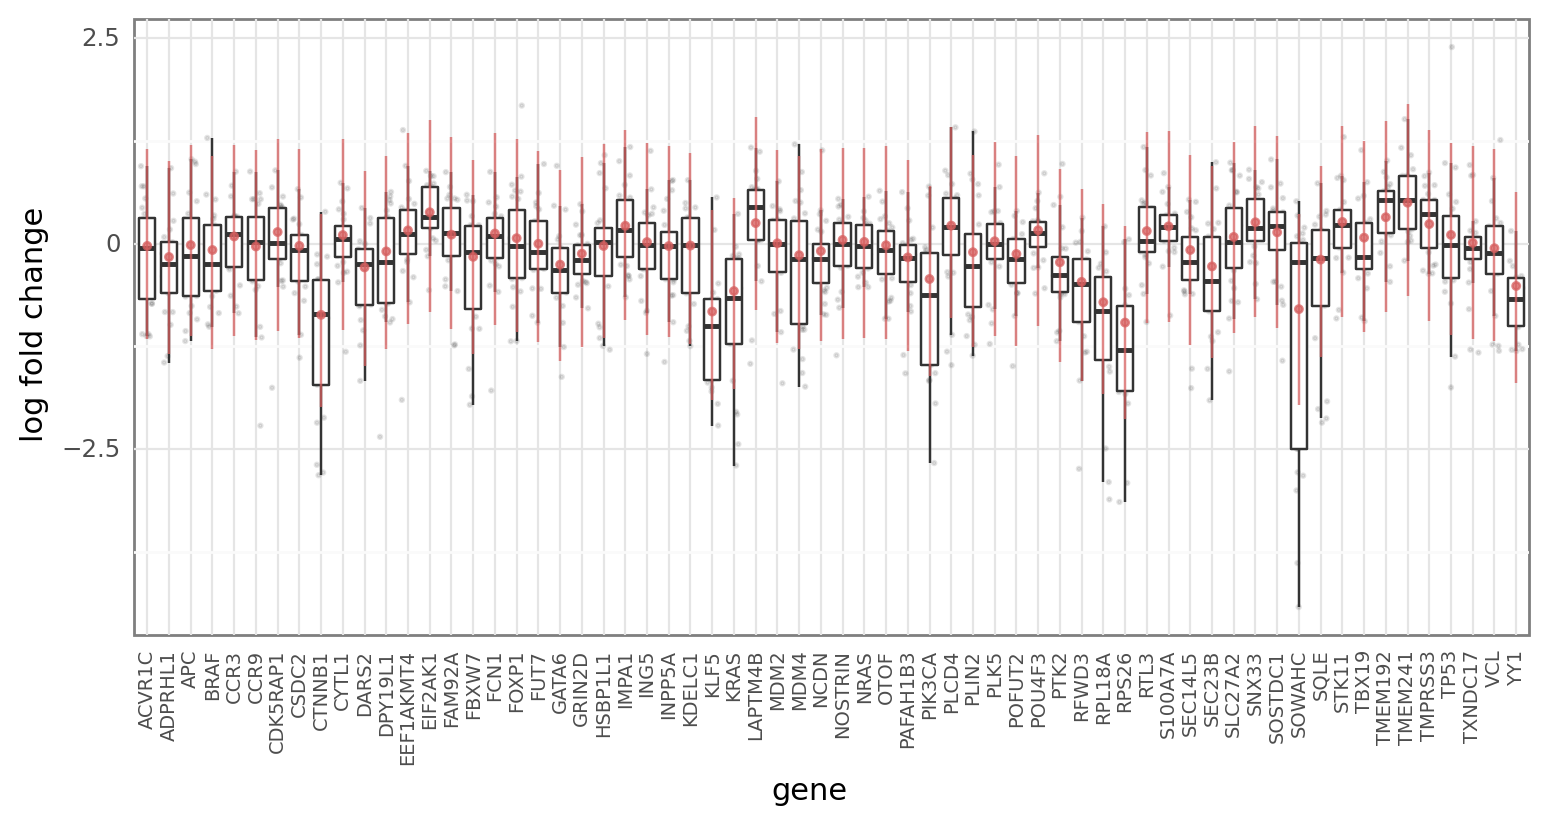

<ggplot: (382606291)>

In [54]:
screen_data = sp5_noncentered.data_manager.get_data()

(
    gg.ggplot(screen_data, gg.aes(x="hugo_symbol", y="lfc"))
    + gg.geom_jitter(alpha=0.1, size=0.3, height=0, width=0.3)
    + gg.geom_boxplot(outlier_alpha=0)
    + gg.geom_point(
        gg.aes(y="mean"),
        data=sp5_posterior_a,
        color=SeabornColor.RED,
        size=1,
        alpha=0.75,
    )
    + gg.geom_linerange(
        gg.aes(y="mean", ymin="hdi_5.5%", ymax="hdi_94.5%"),
        data=sp5_posterior_a,
        color=SeabornColor.RED,
        alpha=0.75,
    )
    + gg.theme(axis_text_x=gg.element_text(angle=90, size=7), figure_size=(9, 4))
    + gg.labs(x="gene", y="log fold change")
)

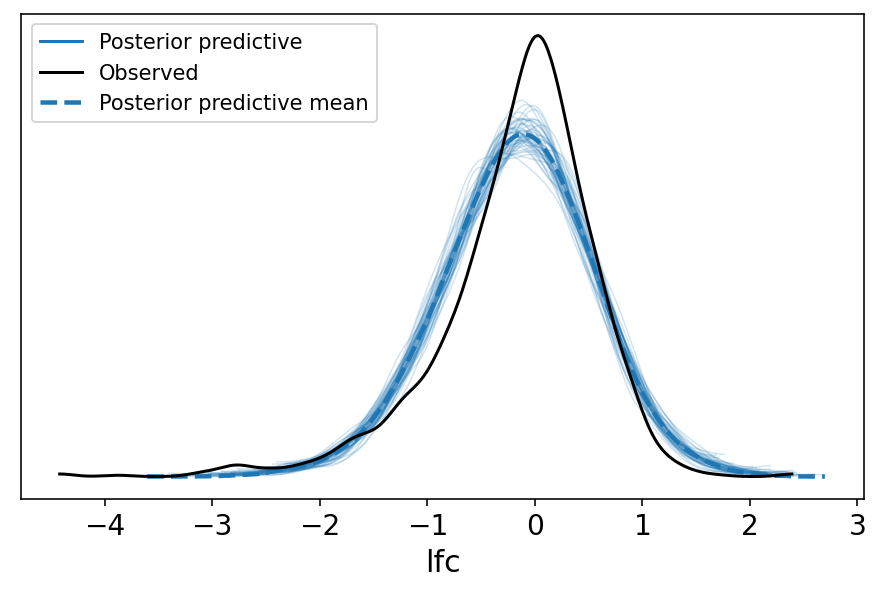

In [19]:
az.plot_ppc(sp5_noncentered.mcmc_results, num_pp_samples=50);

In [57]:
sp7: SpecletSeven = build_and_load_caches("sp7-default")

[07/10/21 13:03:33] WARNING  Dropping 0 sgRNA that map to multiple ]8;id=1625936613.998728-109075;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:250
                             genes.

[07/10/21 13:03:34] WARNING  Dropping 0 data points with missing   ]8;id=1625936614.0103521-558249;file:///Users/admin/Lab_Projects/speclet/src/managers/model_data_managers.py\model_data_managers.py]8;;\:260
                             copy number.

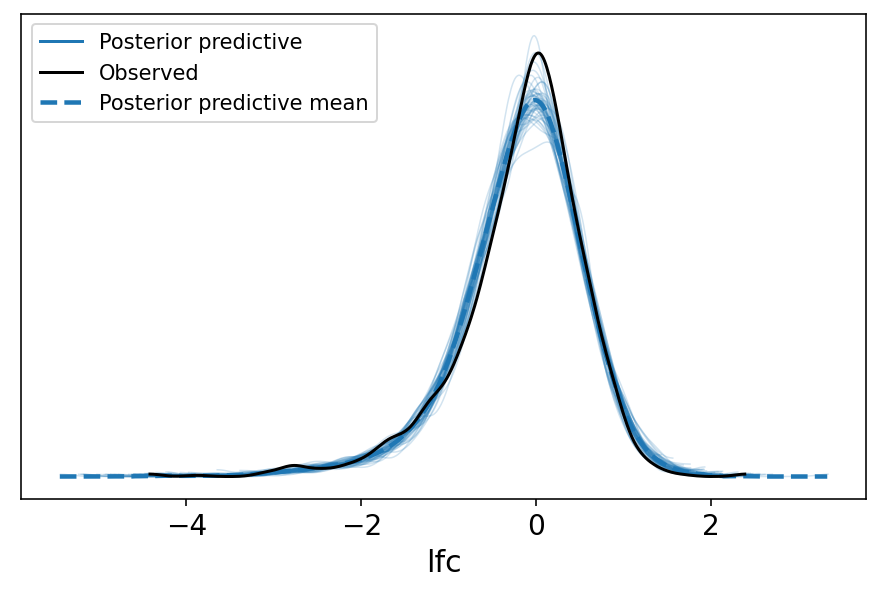

In [58]:
az.plot_ppc(sp7.mcmc_results, num_pp_samples=50);

In [68]:
sp7.data_manager.get_data()[["lineage", "depmap_id"]].drop_duplicates()

lineage   depmap_id
0   colorectal  ACH-000007
1   colorectal  ACH-000249
2   colorectal  ACH-000552
3   colorectal  ACH-000722
4   colorectal  ACH-000969
5   colorectal  ACH-000970
6   colorectal  ACH-000997
7   colorectal  ACH-001345
8   colorectal  ACH-002233
11  colorectal  ACH-000470

In [71]:
sp7_posterior_mu_a = (
    az.summary(sp7.mcmc_results, var_names=["μ_a"], hdi_prob=PYMC3.HDI_PROB)
    .reset_index(drop=False)
    .rename(columns={"index": "parameter"})
    .pipe(
        pmanal.extract_matrix_variable_indices,
        col="parameter",
        idx1=np.array(genes),
        idx2=np.array(cell_lines),
        idx1name="hugo_symbol",
        idx2name="depmap_id",
    )
)

parameter   mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
635  μ_a[63,5] -0.515  0.148    -0.744     -0.286      0.015    0.011   
636  μ_a[63,6] -0.520  0.230    -0.867     -0.146      0.017    0.017   
637  μ_a[63,7] -0.489  0.124    -0.673     -0.287      0.013    0.009   
638  μ_a[63,8] -0.515  0.373    -1.095      0.065      0.022    0.016   
639  μ_a[63,9] -1.124  0.223    -1.462     -0.753      0.010    0.007   

     ess_bulk  ess_tail  r_hat hugo_symbol   depmap_id  
635      87.0     224.0   1.05         YY1  ACH-000970  
636     166.0     238.0   1.04         YY1  ACH-000997  
637      95.0     320.0   1.04         YY1  ACH-001345  
638     269.0     563.0   1.01         YY1  ACH-002233  
639     485.0     819.0   1.00         YY1  ACH-000470

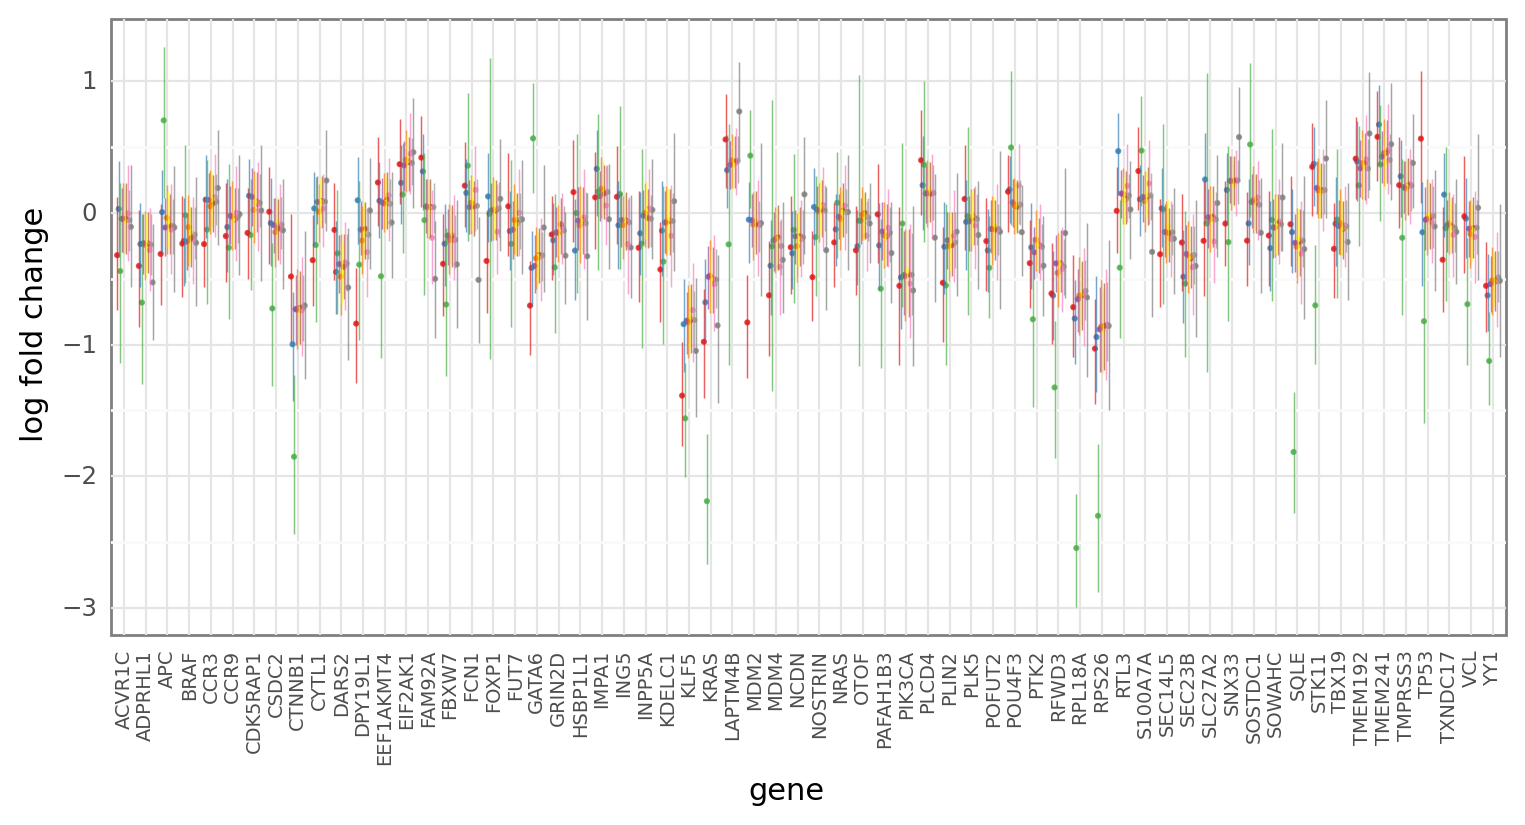

<ggplot: (386998089)>

In [86]:
pos = gg.position_dodge(width=0.7)

(
    gg.ggplot(sp7_posterior_mu_a, gg.aes(x="hugo_symbol", y="mean"))
    + gg.geom_point(gg.aes(color="depmap_id"), size=0.25, position=pos, alpha=0.8)
    + gg.geom_linerange(
        gg.aes(ymin="hdi_5.5%", ymax="hdi_94.5%", color="depmap_id"),
        position=pos,
        size=0.3,
        alpha=0.7,
    )
    + gg.scale_color_brewer(type="qual", palette="Set1")
    + gg.theme(
        axis_text_x=gg.element_text(angle=90, size=7),
        figure_size=(9, 4),
        legend_position="none",
    )
    + gg.labs(x="gene", y="log fold change")
)

**TODO:**

1. add more genes to the plot below
1. add "gene level" average for each gene to plot below


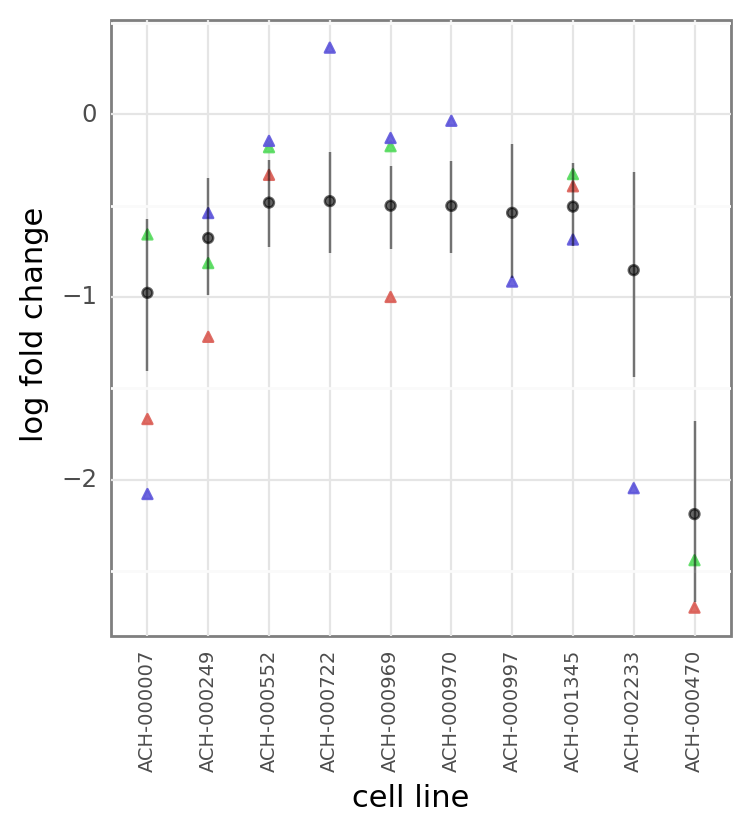

<ggplot: (378464660)>

In [99]:
(
    gg.ggplot(
        screen_data.query("hugo_symbol == 'KRAS'").assign(
            sgrna=lambda d: d.sgrna.to_list()
        ),
        gg.aes(x="depmap_id", y="lfc"),
    )
    + gg.geom_point(gg.aes(color="sgrna"), shape="^", alpha=0.9)
    + gg.geom_linerange(
        gg.aes(y="mean", ymin="hdi_5.5%", ymax="hdi_94.5%"),
        data=sp7_posterior_mu_a.query("hugo_symbol == 'KRAS'"),
        alpha=0.5,
    )
    + gg.geom_point(
        gg.aes(y="mean"),
        data=sp7_posterior_mu_a.query("hugo_symbol == 'KRAS'"),
        alpha=0.6,
    )
    + gg.theme(legend_position="none", axis_text_x=gg.element_text(size=7, angle=90))
    + gg.labs(x="cell line", y="log fold change")
)

---

In [ ]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

In [ ]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m